# Fake News Detection

## 1️⃣ Problem Statement
Predict whether a news is a fake or real based on the text.

Import Required Libraries

In [1]:
#Install the following packages if you haven't already
#!pip install datasets
#!pip install requests

In [2]:
#%pip install nltk

In [3]:
#%pip install wordcloud

In [4]:
#%pip install tensorflow

In [5]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from xgboost import XGBClassifier
from wordcloud import WordCloud
from nltk.util import ngrams
from sklearn.svm import SVC
import re
import string
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

nltk.download('punkt_tab')

# Download necessary NLTK resources
nltk.download("stopwords")
nltk.download("punkt")
# Download the stopwords dataset
nltk.download('stopwords')
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\QC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\QC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\QC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\QC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\QC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\QC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\QC\AppDa

True

## 2️⃣ Load & Explore Dataset

In [6]:
# Directly load the dataset
dataset = load_dataset("ErfanMoosaviMonazzah/fake-news-detection-dataset-English")

# Access the training data
train_data = dataset['train']
print(train_data)


# Convert to pandas DataFrame
df = pd.DataFrame(train_data)

# Display the first few rows of the dataset
print(df.head())

Dataset({
    features: ['Unnamed: 0', 'title', 'text', 'subject', 'date', 'label'],
    num_rows: 30000
})
   Unnamed: 0                                              title  \
0        2619  Ex-CIA head says Trump remarks on Russia inter...   
1       16043  YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...   
2         876  Federal Reserve governor Powell's policy views...   
3       19963  SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...   
4       10783  NANCY PELOSI ARROGANTLY DISMISSES Questions on...   

                                                text          subject  \
0  Former CIA director John Brennan on Friday cri...     politicsNews   
1  How did this man come to OWN this store? There...  Government News   
2  President Donald Trump on Thursday tapped Fede...     politicsNews   
3  Hillary Clinton ally David Brock is offering t...        left-news   
4  Pleading ignorance is a perfect ploy for Nancy...         politics   

                date  label  
0     July 22,

In [7]:
# # Directly load the dataset
# dataset = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset")

# # Access the training data
# train_data = dataset['train']

# # Convert to pandas DataFrame
# df = pd.DataFrame(train_data)

# # Display the first few rows of the dataset
# print(df.head())


In [8]:
df.head()

,Unnamed: 0,title,text,subject,date,label
0,2619,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politicsNews,"July 22, 2017",1
1,16043,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,"Jun 19, 2017",0
2,876,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politicsNews,"November 2, 2017",1
3,19963,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left-news,"Sep 17, 2016",0
4,10783,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,"May 26, 2017",0


### Data cleaning

In [9]:
#deleting unwanted columns that are not needed for the analysis
clean_df = df.drop("Unnamed: 0", axis = 1)
#clean_df = df.drop("title", axis = 1)
#clean_df = df.drop("subject", axis = 1)

In [10]:
# Check for missing values
print("Missing Values:\n", clean_df.isnull().sum())

Missing Values:
 title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [11]:
#reset index
clean_df = clean_df.reset_index(drop=True)

Shuffle Rows Randomly

In [12]:
clean_df = df.sample(frac = 1)

### Explore Data

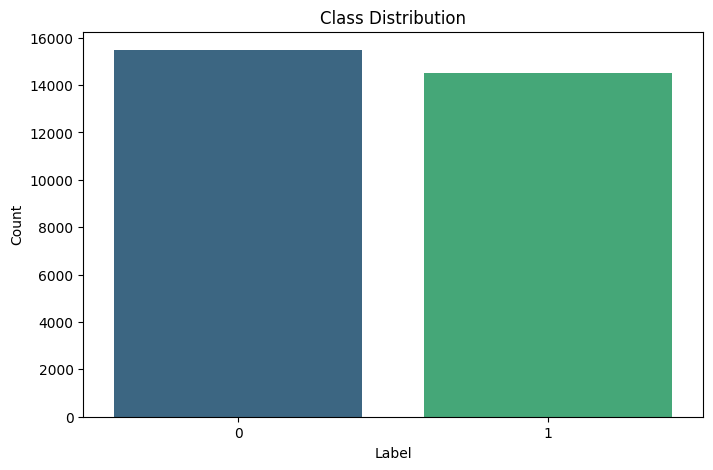

In [ ]:
# Check class distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=clean_df, x="label", palette="viridis", hue="label", legend=False)
plt.title("Class Distribution")
plt.xlabel("Label")  # Optional: label for x-axis
plt.ylabel("Count")  # Optional: label for y-axis
plt.savefig("../images/class_distribution.png")
plt.show()

Text(0.5, 1.0, 'Number of Samples in Subject')

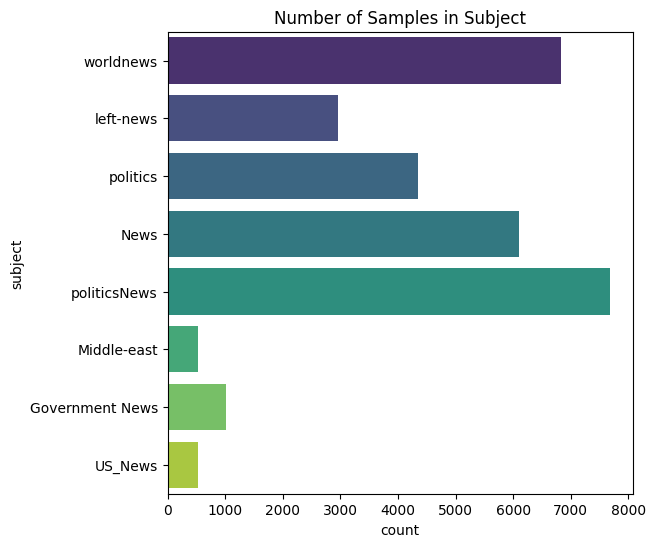

In [ ]:
# Plotting The Number Of Samples In 'subject'
plt.figure(figsize=(6, 6))
sns.countplot(y="subject", data=clean_df, palette="viridis", hue="subject", legend=False)
plt.title("Number of Samples in Subject")
plt.savefig("../images/subject_count.png", dpi=300, bbox_inches="tight")
plt.show()

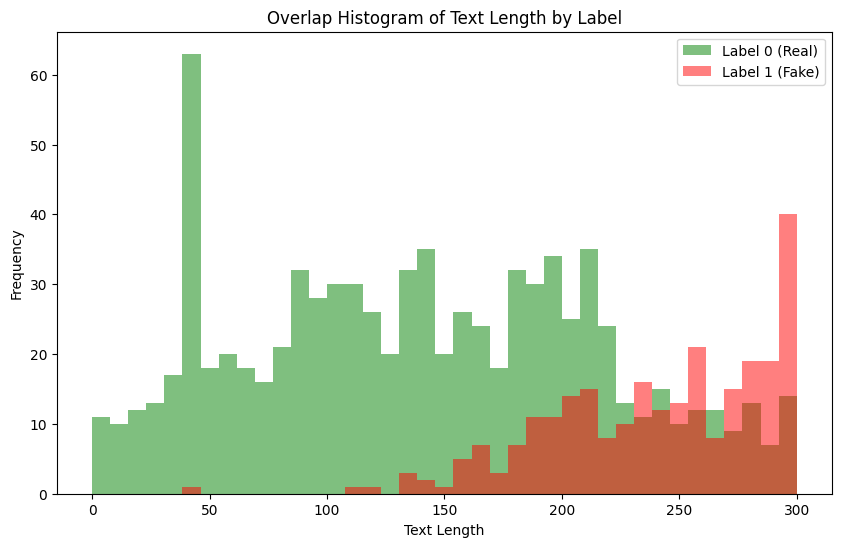

In [ ]:
# Define bins for the histogram
bins = np.linspace(0, 300, 40)

# Plot overlapping histograms for label 0 and label 1
plt.figure(figsize=(10, 6))
plt.hist(clean_df[clean_df["label"] == 0]["text"].str.len(), bins, alpha=0.5, label="Label 0 (Real)", color="green")
plt.hist(clean_df[clean_df["label"] == 1]["text"].str.len(), bins, alpha=0.5, label="Label 1 (Fake)", color="red")
plt.legend(loc="upper right")
plt.title("Overlap Histogram of Text Length by Label")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.savefig("../images/overlap_histogram.png")
plt.show()

Function to remove stopwords & convert it lowercase 

In [16]:
# Define the cleaning function
def data_cleaning(text):
    stop_words = set(stopwords.words("english"))
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    text = str(text)

    # Remove non-alphabet characters, URLs, and extra spaces
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub('(^\s+|\s+$)', ' ', text)
    text = re.sub("@[\w\d]+", ' ', text)  # Remove @ mentions
    text = re.sub("http:[\w\:\/\.]+", ' ', text)  # Remove URLs

    # Convert to lowercase and tokenize
    text = text.lower()
    tokens = word_tokenize(text)

    # Remove stopwords and apply lemmatization
    tokens = [token for token in tokens if len(token) > 1]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into a string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# Apply data cleaning function to the DataFrame
clean_df["cleaned_text"] = clean_df["text"].apply(data_cleaning)
clean_df.head()

,Unnamed: 0,title,text,subject,date,label,cleaned_text
4697,13487,Russia's ruling party says to back Putin if he...,Russia s ruling United Russia party will suppo...,worldnews,"November 30, 2017",1,russia ruling united russia party support pres...
29480,18435,"DEM REP, WIFE OF FELON CAUGHT On Tape Bragging...",Democratic Rep. Jan Schakowsky (Ill.) is marri...,left-news,"Jun 26, 2017",0,democratic rep jan schakowsky ill married robe...
15568,15590,SHOULD THIS RACIST GIRL BE FIRED FOR BEHAVING ...,Perhaps this young girl aspires to be the Firs...,politics,"Jun 9, 2015",0,perhaps young girl aspires first lady someday ...
4075,6630,"When A Journalist Covers Trump, They Get Death...",Journalist Julia Ioffe did a profile of Donald...,News,"April 29, 2016",0,journalist julia ioffe profile donald trump wi...
11975,18188,WHILE DEMOCRATS Were Focused On Russia and P*s...,The Democrats and their allies in the media wo...,left-news,"Aug 7, 2017",0,democrat ally medium would like believe presid...


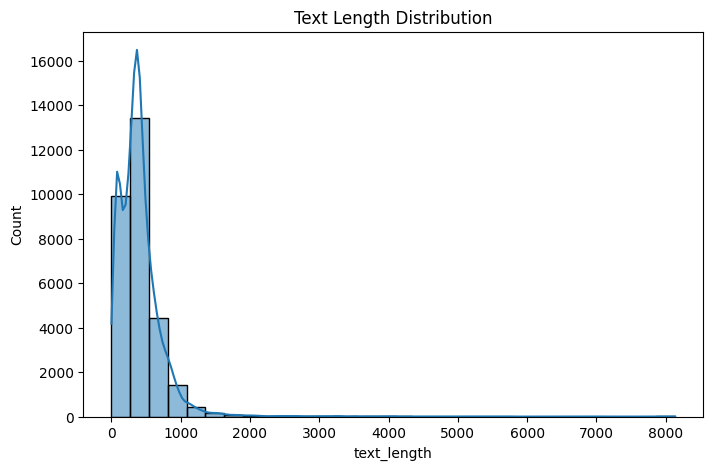

In [ ]:
# Check text length distribution
clean_df['text_length'] = clean_df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(clean_df['text_length'], bins=30, kde=True)
plt.title("Text Length Distribution")
plt.savefig("text_length_distribution.png")
plt.show()

Frequency of Top Common words in Original and Clean Text

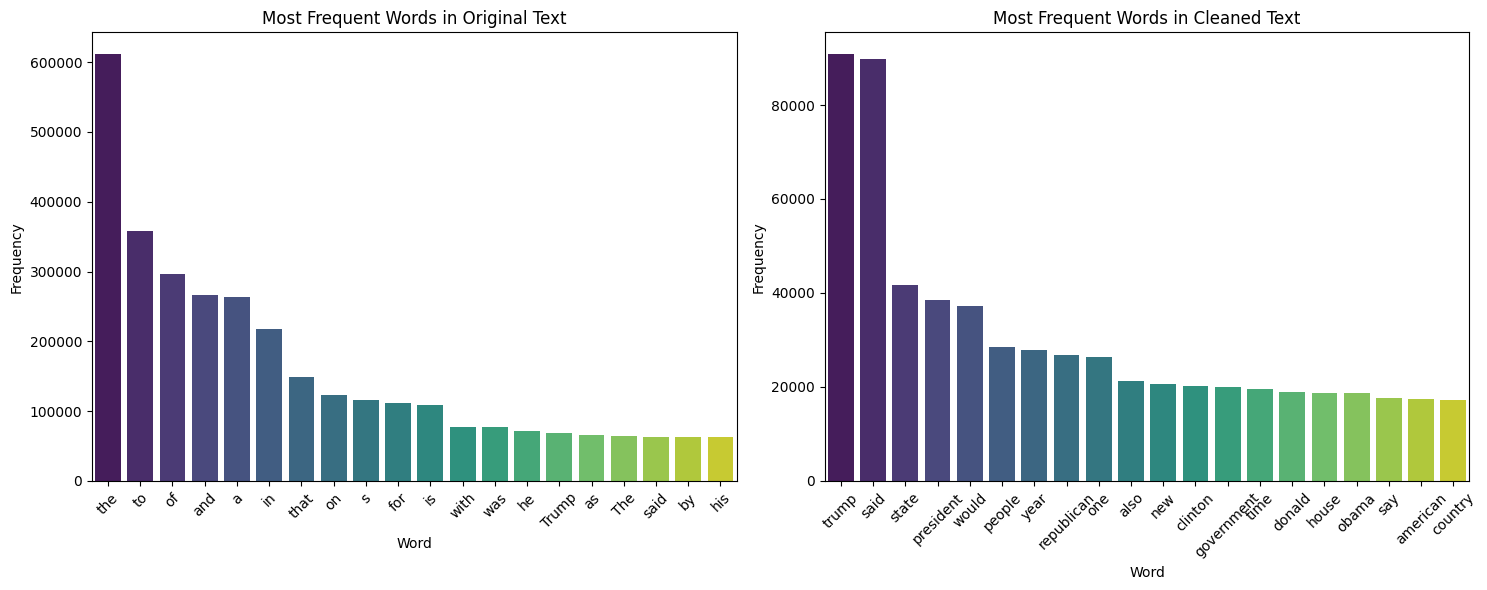

In [ ]:
# Tokenize all text in the 'text' column
all_words_text = " ".join( clean_df["text"]).split()

# Tokenize all text in the 'cleaned_text' column
all_words_cleaned = " ".join(clean_df["cleaned_text"]).split()

# Count word frequency for both columns
word_freq_text = Counter(all_words_text)
word_freq_cleaned = Counter(all_words_cleaned)

# Get the most common 20 words for both
common_words_text = word_freq_text.most_common(20)
common_words_cleaned = word_freq_cleaned.most_common(20)

# Convert both to DataFrames
common_df_text = pd.DataFrame(common_words_text, columns=["Word", "Frequency"])
common_df_cleaned = pd.DataFrame(common_words_cleaned, columns=["Word", "Frequency"])

# Create side-by-side subplots
plt.figure(figsize=(15, 6))

# Plot most common words for 'text' column in the first subplot
plt.subplot(1, 2, 1)  # (rows, cols, position)
sns.barplot(x="Word", y="Frequency", data=common_df_text, palette="viridis", hue="Word", legend=False)
plt.xticks(rotation=45)
plt.title("Most Frequent Words in Original Text")

# Plot most common words for 'cleaned_text' column in the second subplot
plt.subplot(1, 2, 2)  # (rows, cols, position)
sns.barplot(x="Word", y="Frequency", data=common_df_cleaned, palette="viridis", hue="Word", legend=False)
plt.xticks(rotation=45)
plt.title("Most Frequent Words in Cleaned Text")

# Display both plots side by side
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig("../images/word_frequency.png", dpi=300, bbox_inches='tight')
plt.show()

Frequency of Top Bigrams in Original and Clean Text

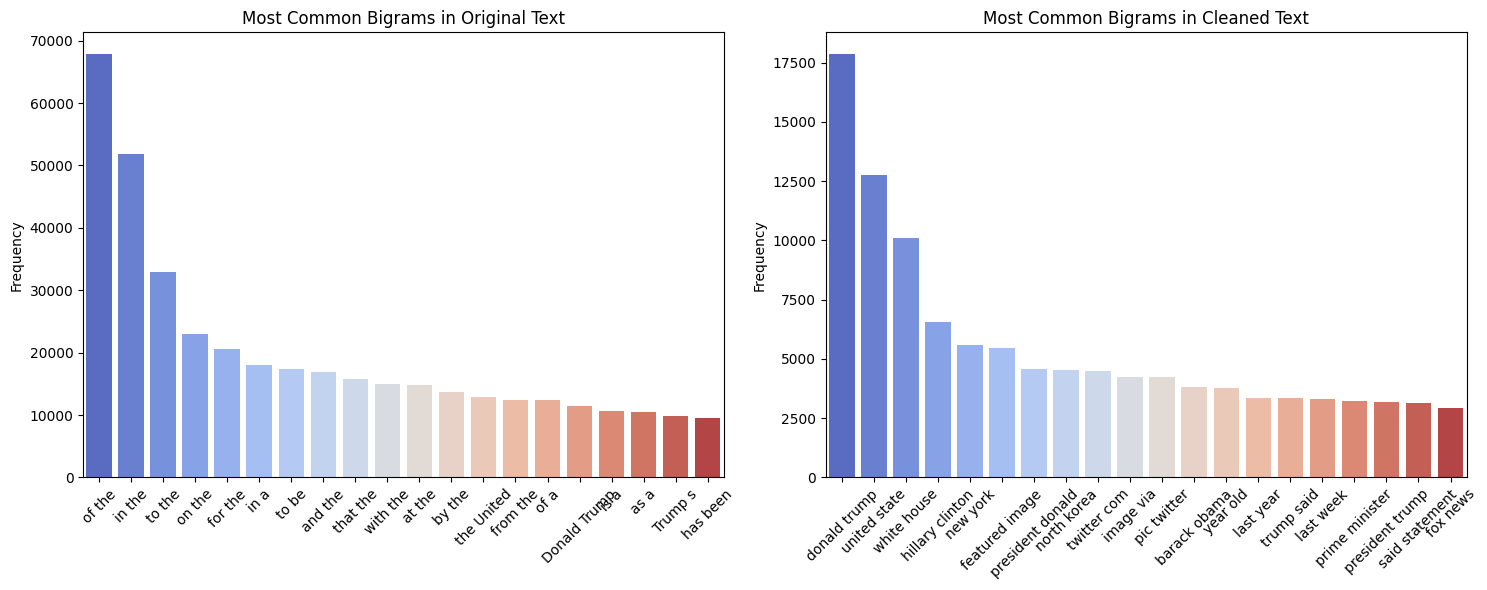

In [ ]:
# Function to extract top n-grams
def get_top_ngrams(text_series, n, top_n=20):
    all_words = " ".join(text_series).split()
    ngrams_list = list(ngrams(all_words, n))
    ngram_freq = Counter(ngrams_list)
    return ngram_freq.most_common(top_n)

# Get top bigrams for 'text' column
bigrams_text = get_top_ngrams(clean_df["text"], 2)

# Get top bigrams for 'cleaned_text' column
bigrams_cleaned = get_top_ngrams(clean_df["cleaned_text"], 2)

# Convert both to DataFrames
bigram_df_text = pd.DataFrame(bigrams_text, columns=["Bigram", "Frequency"])
bigram_df_cleaned = pd.DataFrame(bigrams_cleaned, columns=["Bigram", "Frequency"])

# Create side-by-side subplots
plt.figure(figsize=(15, 6))

# Plot bigrams for 'text' column in the first subplot
plt.subplot(1, 2, 1)  # (rows, cols, position)
sns.barplot(x=[" ".join(b) for b in bigram_df_text["Bigram"]], y=bigram_df_text["Frequency"], palette="coolwarm", hue=[" ".join(b) for b in bigram_df_text["Bigram"]], legend=False)
plt.xticks(rotation=45)
plt.title("Most Common Bigrams in Original Text")

# Plot bigrams for 'cleaned_text' column in the second subplot
plt.subplot(1, 2, 2)  # (rows, cols, position)
sns.barplot(x=[" ".join(b) for b in bigram_df_cleaned["Bigram"]], y=bigram_df_cleaned["Frequency"], palette="coolwarm", hue=[" ".join(b) for b in bigram_df_cleaned["Bigram"]], legend=False)
plt.xticks(rotation=45)
plt.title("Most Common Bigrams in Cleaned Text")

# Display both plots side by side
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig("../images/bigrams.png", dpi=300, bbox_inches='tight')
plt.show()

Top Words in Original and Clean Text

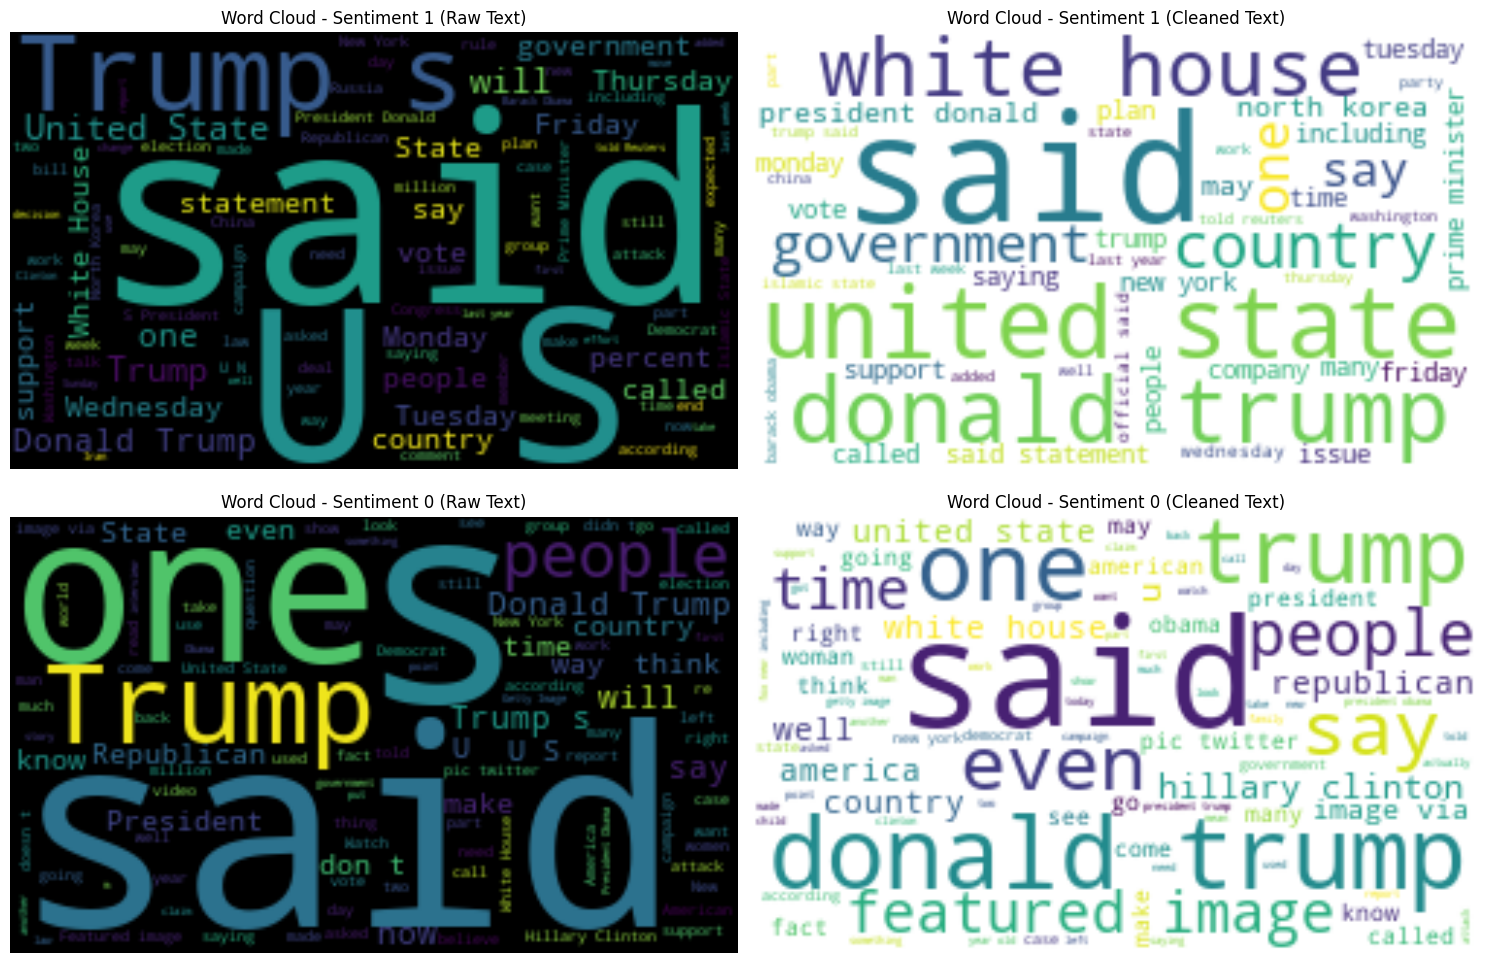

In [20]:
# Get unique labels
unique_labels = clean_df["label"].unique()
n_labels = len(unique_labels)

# Create figure with appropriate size (2 columns, n_labels rows)
plt.figure(figsize=(15, 5*n_labels))

for i, label in enumerate(unique_labels):
    # First subplot: Word cloud for 'text' column
    plt.subplot(n_labels, 2, i*2+1)
    words_text = " ".join(clean_df[clean_df["label"] == label]["text"])
    wordcloud_text = WordCloud(width=250, height=150, background_color="black").generate(words_text)
    plt.imshow(wordcloud_text, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - Sentiment {label} (Raw Text)")

    # Second subplot: Word cloud for 'cleaned_text' column
    plt.subplot(n_labels, 2, i*2+2)
    words_cleaned = " ".join(clean_df[clean_df["label"] == label]["cleaned_text"])
    wordcloud_cleaned = WordCloud(width=250, height=150, background_color="white").generate(words_cleaned)
    plt.imshow(wordcloud_cleaned, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - Sentiment {label} (Cleaned Text)")

plt.tight_layout()
plt.show()

More Graph Ideas: histogram of fake , real news


bae plot of text, title, label

### TF-IDF (Term Frequency-Inverse Document Frequency)
Assigns weights to words based on importance in the document and corpus.

In [21]:

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(clean_df["cleaned_text"])

# Convert to DataFrame
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display TF-IDF features
print(X_tfidf_df.head())

   abadi  abandon  abandoned  abbas  abc  abdullah  abe  abedin  ability  \
0    0.0      0.0        0.0    0.0  0.0       0.0  0.0     0.0      0.0   
1    0.0      0.0        0.0    0.0  0.0       0.0  0.0     0.0      0.0   
2    0.0      0.0        0.0    0.0  0.0       0.0  0.0     0.0      0.0   
3    0.0      0.0        0.0    0.0  0.0       0.0  0.0     0.0      0.0   
4    0.0      0.0        0.0    0.0  0.0       0.0  0.0     0.0      0.0   

   able  ...   youtube  ypg  zealand      zero  zika  zimbabwe  zinke  zone  \
0   0.0  ...  0.000000  0.0      0.0  0.000000   0.0       0.0    0.0   0.0   
1   0.0  ...  0.000000  0.0      0.0  0.000000   0.0       0.0    0.0   0.0   
2   0.0  ...  0.000000  0.0      0.0  0.114917   0.0       0.0    0.0   0.0   
3   0.0  ...  0.067091  0.0      0.0  0.000000   0.0       0.0    0.0   0.0   
4   0.0  ...  0.000000  0.0      0.0  0.000000   0.0       0.0    0.0   0.0   

   zor  zuma  
0  0.0   0.0  
1  0.0   0.0  
2  0.0   0.0  
3  0.0  

## 3️⃣ Preprocessing Data

### Extract Input, Output Variables

In [22]:
# Define X (features) and y (labels)
X = X_tfidf # Cleaned_text 
y = clean_df["label"]


### Split Dataset

In [23]:
# Train-test split (80-20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (24000, 5000)
Testing Data Shape: (6000, 5000)


## 4️⃣ Train and Evaluate Model

### 1) Navive Bayes

In [24]:
# Train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)

### 2) Logistics Regression 

In [25]:
# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

Evaluate both models with a single function

In [26]:
# Define a function for evaluation
def evaluate_model(model_name, y_test, y_pred):
    print(f"\n🔹 Model: {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Evaluate models
evaluate_model("Naive Bayes", y_test, nb_preds)
evaluate_model("Logistic Regression", y_test, lr_preds)


🔹 Model: Naive Bayes
Accuracy: 0.9265
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      3078
           1       0.92      0.93      0.92      2922

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000

Confusion Matrix:
 [[2853  225]
 [ 216 2706]]

🔹 Model: Logistic Regression
Accuracy: 0.976
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      3078
           1       0.97      0.98      0.98      2922

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000

Confusion Matrix:
 [[2984   94]
 [  50 2872]]


In [ ]:
# Confusion Matrix for Logistic Regression
sns.heatmap(confusion_matrix(y_test, lr_preds), annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("../images/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

### 3) Train XGBoost Model

In [28]:
# Train XGBoost Model
xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy: {xgb_accuracy:.2f}")

Accuracy: 0.98


### 4) Support Vector Machine

In [29]:
# Support Vector Machine
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
print("Support Vector Machine Report:")
print(classification_report(y_test, svm_preds))

Support Vector Machine Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3078
           1       0.98      0.99      0.98      2922

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



### 5) Random Forest

In [30]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest Report:")
print(classification_report(y_test, rf_preds))

Random Forest Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3078
           1       0.98      0.99      0.98      2922

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



### Comparision of All Models

C:\Users\QC\AppData\Local\Temp\ipykernel_11900\315317065.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=model_names, y=accuracies_percentage, palette="viridis")


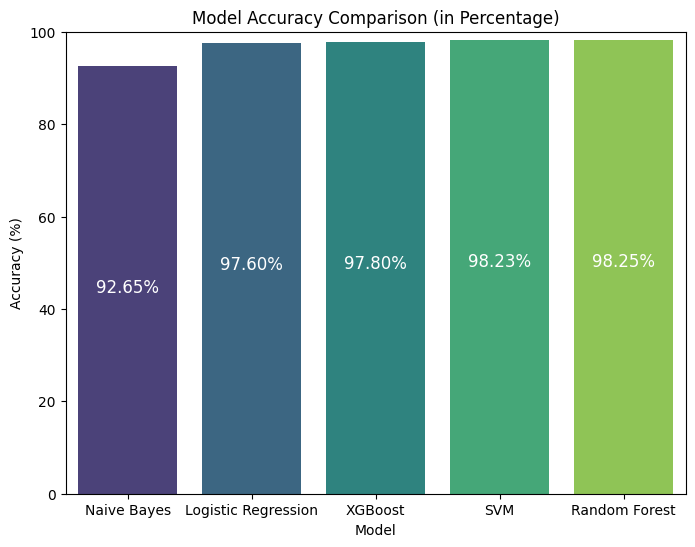

In [55]:
# Define model names and their respective accuracies in percentage
model_names = ["Naive Bayes", "Logistic Regression", "XGBoost", "SVM", "Random Forest"]
accuracies_percentage = [
    accuracy_score(y_test, nb_preds) * 100,
    accuracy_score(y_test, lr_preds) * 100,
    xgb_accuracy * 100,
    accuracy_score(y_test, svm_preds) * 100,
    accuracy_score(y_test, rf_preds) * 100
]

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = sns.barplot(x=model_names, y=accuracies_percentage, palette="viridis")

# Add text labels with each bar's value
for bar, accuracy in zip(bars.patches, accuracies_percentage):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate
        #bar.get_height() + 1,              # Y-coordinate (slightly above the bar)
        bar.get_height()-50,              # Y-coordinate (slightly above the bar)
        f"{accuracy:.2f}%",                # Text label
        ha="center", va="bottom", fontsize=12, color="white"
    )

# Customize the chart
plt.title("Model Accuracy Comparison (in Percentage)")
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)  # Set y-axis range to [0, 100]
plt.savefig("../images/model_accuracy_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

## 5️⃣ Prediction on New Data

In [31]:
#def predict_sentiment(text, model):
 #   cleaned_text = data_cleaning(text)
  #  print(cleaned_text)
   # text_vectorized = tfidf_vectorizer.transform([cleaned_text])
    #prediction = model.predict(text_vectorized)
    #return prediction[0]

# Test the model with a sample text
#sample_text = "Trump is working hard for US."
#print("Predicted Sentiment:", predict_sentiment(sample_text, lr_model))
